In [1]:
from __future__ import print_function, division

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [28]:
nino3 = np.genfromtxt ('tas_Amon_IPSL-CM5A-LR_past1000_r1i1p1_0850_1850_1_nino3_tseries.csv', delimiter=",")
ismr = np.genfromtxt ('pr_Amon_IPSL-CM5A-LR_past1000_r1i1p1_0850_1850_india_goswami_2002_tseries.csv', delimiter=",")
vrf = np.genfromtxt ('sigl.txt', delimiter=",")
print(nino3.shape)
print(ismr.shape)
print(vrf.shape)

(12012,)
(12012,)
(1001,)


In [3]:
def common_time_axis(dismr, verbose=True):
    """
    Generates common time axis for Nino3 and ISMR time series.
    """
    # generate the time axis
    Nt = len(dismr)
    time = [dt.datetime(850, 1, 15)]
    for i in range(1, len(dismr)):
        y = time[i - 1].year
        m = time[i - 1].month
        if m == 12:
            y += 1
            m = 0
        time.append(dt.datetime(y, m + 1, 15))
    time = np.array(time)

    return time
def yearly_time_axis(dvolc, verbose=True):
    """
    Generates time axis for yearly data 
    """
    Nt = len(dvolc)
    time = [dt.datetime(900, 1, 15)]
    for i in range(1, len(dvolc)):
        y = time[i - 1].year
        y += 1
        time.append(dt.datetime(y, 1, 15))
    time = np.array(time)

    return time
def moving_average_anomaly(dismr,n=360):
    """
    Generates moving average anomaly of long time series
    """
    #print(dismr.shape)
    dismr_anom = np.zeros((dismr.shape[0]))
    dismr_std = np.zeros((dismr.shape[0]))
    dismr_anom[0:n/2] = ( dismr[0:n/2] - np.mean(dismr[0:n]) )/np.std(dismr[0:n])
    dismr_anom[dismr.shape[0]-n/2:] = ( dismr[dismr.shape[0]-n/2:] - np.mean(dismr[dismr.shape[0]-n:]) )/np.std(dismr[dismr.shape[0]-n:])
    #print(dismr_anom)
    dismr_std[0:n/2] = np.std(dismr[0:n])
    dismr_std[dismr.shape[0]-n/2:] = np.std(dismr[dismr.shape[0]-n:])
    
    for i in range(np.int(n/2),np.int(dismr.shape[0]-n/2)):
        dismr_anom[i] = (dismr[i] - np.mean(dismr[i-n/2:i+n/2]))/np.std(dismr[i-n/2:i+n/2])
        dismr_std[i] = np.std(dismr[i-n/2:i+n/2])
    return dismr_anom, dismr_std

def EventSync(es1, es2, taumax):
    """
    Compute non-vectorized event synchronization
    :type es1: 1D Numpy array
    :arg es1: Event series containing '0's and '1's
    :type es2: 1D Numpy array
    :arg es2: Event series containing '0's and '1's
    :float return: Event synchronization es2 to es1
    """
    ex = np.arange(len(es1))[es1 == 1]
    ey = np.arange(len(es2))[es2 == 1]
    lx = len(ex)
    ly = len(ey)

    count = 0
    if lx!=0 and ly!=0:
        for m in range(1, lx-1):
            for n in range(1, ly-1):
                dst = ex[m] - ey[n]

                if abs(dst) > taumax:
                    continue
                elif dst == 0:
                    count += 0.5
                    continue

              # finding the dynamical delay tau
                tmp = ex[m+1] - ex[m]
                if tmp > ex[m] - ex[m-1]:
                    tmp = ex[m] - ex[m-1]
                tau = ey[n+1] - ey[n]
                if tau > ey[n] - ey[n-1]:
                    tau = ey[n] - ey[n-1]
                if tau > tmp:
                    tau = tmp
                tau = tau / 2

                if dst > 0 and dst <= tau:
                    count += 1

    #print("count = ",count) 
    #print("Q = ",np.sqrt((lx-2) * (ly-2))) 
    #print("lx,ly,Q =",lx,ly,count) 
    if lx!=0 and ly!=0:
        return count / np.sqrt((lx) * (ly))
      #return count / np.sqrt((lx-2) * (ly-2))
    else:
        return 0.0


In [23]:
ismr_anom = (ismr - np.mean(ismr))/np.std(ismr)
nino3_anom = (nino3 - np.mean(nino3))/np.std(nino3)

es_ismr_d = np.zeros((ismr_anom.shape[0]))
es_ismr_f = np.zeros((ismr_anom.shape[0]))
es_nino3_en = np.zeros((nino3_anom.shape[0]))
es_nino3_ln = np.zeros((nino3_anom.shape[0]))

es_ismr_f[ismr_anom>1.0] = 1.0
es_ismr_d[ismr_anom<-1.0] = 1.0
es_nino3_en[nino3_anom>0.5] = 1.0
es_nino3_ln[nino3_anom<-0.5] = 1.0

taumax = 60

In [24]:
Q_hist_ed = np.zeros((es_ismr_d.shape[0]-taumax))
Q_hist_lf = np.zeros((es_ismr_d.shape[0]-taumax))

for i in range(es_ismr_d.shape[0]-taumax):
    Q_hist_12 = EventSync(es_ismr_d[i:i+taumax], es_nino3_en[i:i+taumax], taumax)
    Q_hist_21 = EventSync(es_nino3_en[i:i+taumax], es_ismr_d[i:i+taumax],taumax)
    Q_hist_ed[i] = Q_hist_12 + Q_hist_21

    Q_hist_12 = EventSync(es_ismr_f[i:i+taumax], es_nino3_ln[i:i+taumax], taumax)
    Q_hist_21 = EventSync(es_nino3_ln[i:i+taumax], es_ismr_f[i:i+taumax],taumax)
    Q_hist_lf[i] = Q_hist_12 + Q_hist_21


In [25]:
np.savetxt("Q_hist_ed.csv", Q_hist_ed, delimiter=",")
np.savetxt("Q_hist_lf.csv", Q_hist_lf, delimiter=",")

In [27]:
max(ismr_anom)

4.1770612957229076

In [29]:
np.mean(ismr)

2.1677931465378942e-05

In [30]:
np.std(ismr)

2.7958212788067276e-05

In [31]:
ismr_anom = (ismr-np.mean(ismr))/np.std(ismr)

In [32]:
min(ismr_anom)

-0.77536899799935022

In [33]:
max(ismr_anom)

4.1770612957229076

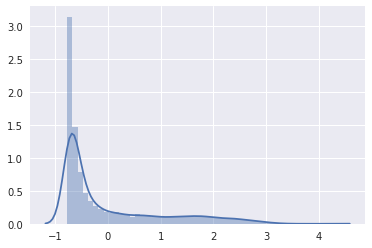

In [34]:
sns.distplot(ismr_anom)